#                                                Assignment - 2 Group - 64

Distributed and Parallel Training of CBOW using a Parameter Server Architecture

Benchmarking with 1 workers...
Benchmarking with 2 workers...
Benchmarking with 4 workers...

SPEEDUP TABLE
Workers    | Time (s)   | Throughput      | Speedup   
1          | 0.92       | 109.21          | 1.00      
2          | 1.22       | 163.90          | 0.75      
4          | 2.36       | 169.66          | 0.39      


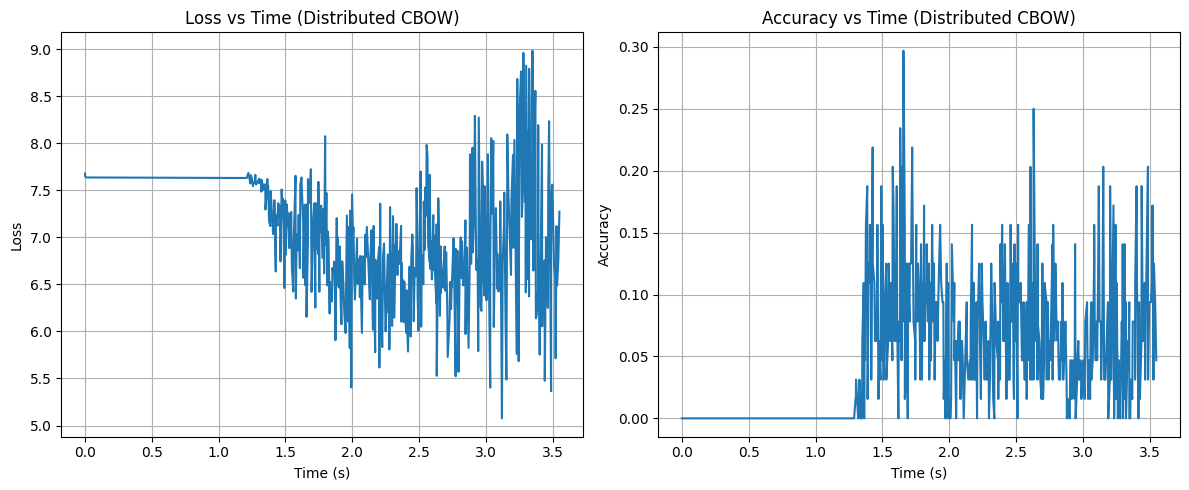

Plots saved to performance_plots.png


In [4]:

# Importing required package and libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import time
import queue
import requests
import re
from collections import Counter
import matplotlib.pyplot as plt


# Distributed CBOW with Real Data & Benchmarking
# -------------------------------------------------
# 1. Configuration
VOCAB_SIZE = 2000
EMBED_DIM = 50
CONTEXT_SIZE = 2
BATCH_SIZE = 64
NUM_STEPS = 100 # Steps per worker
LEARNING_RATE = 0.05

# 2. Data Preparation
def prepare_data():
    file_path = "dataset.txt"
    if not os.path.exists(file_path):
        url = "https://www.gutenberg.org/files/57421/57421-0.txt"
        print(f"Downloading dataset from {url}...")
        response = requests.get(url)
        if response.status_code == 200:
            text = response.text
            start_marker = "*** START OF THIS PROJECT GUTENBERG EBOOK"
            end_marker = "*** END OF THIS PROJECT GUTENBERG EBOOK"
            start_idx = text.find(start_marker)
            end_idx = text.find(end_marker)
            if start_idx != -1:
                start_idx = text.find("\n", start_idx) + 1
            if end_idx != -1:
                text = text[start_idx:end_idx]
            elif start_idx != -1:
                text = text[start_idx:]
            with open(file_path, "w", encoding="utf-8") as f:
                f.write(text)
            print("Download complete.")
        else:
            raise Exception("Failed to download dataset.")

    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read().lower()

    # Simple tokenization
    tokens = re.findall(r'\w+', text)
    word_counts = Counter(tokens)
    vocab = [w for w, c in word_counts.most_common(VOCAB_SIZE - 1)]
    vocab.append("<UNK>")
    word_to_idx = {w: i for i, w in enumerate(vocab)}

    data = [word_to_idx.get(w, word_to_idx["<UNK>"]) for w in tokens]
    return data, vocab, word_to_idx

# 3. CBOW Model
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        avg_embed = torch.mean(embeds, dim=1)
        out = self.linear(avg_embed)
        return out

# 4. Parameter Server
def run_parameter_server(num_workers, grad_queue, param_queues, results_queue):
    model = CBOWModel(VOCAB_SIZE, EMBED_DIM)
    model.share_memory()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    total_updates = 0
    expected_updates = NUM_STEPS * num_workers
    start_time = time.time()

    while total_updates < expected_updates:
        try:
            rank, grads = grad_queue.get(timeout=20)
            optimizer.zero_grad()
            for param, grad in zip(model.parameters(), grads):
                param.grad = torch.tensor(grad)
            optimizer.step()

            # Send weights back
            state = {k: v.detach().cpu().numpy() for k, v in model.state_dict().items()}
            param_queues[rank].put(state)
            total_updates += 1
        except queue.Empty:
            break

    end_time = time.time()
    results_queue.put({
        "num_workers": num_workers,
        "total_time": end_time - start_time,
        "updates": total_updates
    })

# 5. Worker
def run_worker(rank, data, grad_queue, param_queue, metrics_queue):
    model = CBOWModel(VOCAB_SIZE, EMBED_DIM)
    criterion = nn.CrossEntropyLoss()

    # Each worker starts from a different part of the data
    start_offset = random.randint(0, len(data) - BATCH_SIZE - 1000)

    for step in range(NUM_STEPS):
        # Sample context windows
        inputs = []
        targets = []
        for _ in range(BATCH_SIZE):
            idx = (start_offset + step * BATCH_SIZE + random.randint(0, 100)) % (len(data) - CONTEXT_SIZE * 2)
            context = data[idx : idx + CONTEXT_SIZE] + data[idx + CONTEXT_SIZE + 1 : idx + CONTEXT_SIZE * 2 + 1]
            target = data[idx + CONTEXT_SIZE]
            inputs.append(context)
            targets.append(target)

        inputs = torch.LongTensor(inputs)
        targets = torch.LongTensor(targets)

        # Train
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()

        # Accuracy
        preds = torch.argmax(output, dim=1)
        acc = (preds == targets).float().mean().item()

        # Push Grads
        grad_queue.put((
            rank,
            [p.grad.detach().cpu().numpy() for p in model.parameters()]
        ))

        # Update Metrics
        metrics_queue.put({
                  "worker": rank,
                  "step": step,
                  "loss": loss.item(),
                  "acc": acc,
                  "time": time.time()
              })


        # Pull Weights
        new_state = param_queue.get()
        new_state = {k: torch.tensor(v) for k, v in new_state.items()}
        model.load_state_dict(new_state)

def benchmark(n_workers, data):
    print(f"Benchmarking with {n_workers} workers...")
    grad_queue = mp.Queue()
    param_queues = {i: mp.Queue() for i in range(1, n_workers + 1)}
    results_queue = mp.Queue()
    metrics_queue = mp.Queue()

    processes = []
    p_server = mp.Process(target=run_parameter_server, args=(n_workers, grad_queue, param_queues, results_queue))
    p_server.start()
    processes.append(p_server)

    for i in range(1, n_workers + 1):
        p = mp.Process(target=run_worker, args=(i, data, grad_queue, param_queues[i], metrics_queue))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    summary = results_queue.get()

    metrics = []
    while True:
        try:
            metrics.append(metrics_queue.get_nowait())
        except queue.Empty:
            break

    return summary, metrics

import random

if __name__ == "__main__":
    data, vocab, word_to_idx = prepare_data()

    all_results = []
    all_metrics = {}

    # Run for 1, 2, 4 workers
    worker_counts = [1, 2, 4]
    for n in worker_counts:
        res, met = benchmark(n, data)
        all_results.append(res)
        if n == 4: # Store metrics from the largest configuration for plotting
            all_metrics = met

    # --- Reporting  SPEEDUP TABLE ---
    print("\n" + "="*30)
    print("SPEEDUP TABLE")
    print("="*30)
    print(f"{'Workers':<10} | {'Time (s)':<10} | {'Throughput':<15} | {'Speedup':<10}")

    t1 = all_results[0]['total_time']
    for res in all_results:
        n = res['num_workers']
        t = res['total_time']
        throughput = res['updates'] / t
        speedup = t1 / t if t > 0 else 0
        print(f"{n:<10} | {t:<10.2f} | {throughput:<15.2f} | {speedup:<10.2f}")

    # --- Plotting ---
if len(all_metrics) > 0:
    all_metrics = sorted(all_metrics, key=lambda x: x["time"])
    t0 = all_metrics[0]["time"]

    times = [m["time"] - t0 for m in all_metrics]
    losses = [m["loss"] for m in all_metrics]
    accs = [m["acc"] for m in all_metrics]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(times, losses)
    plt.xlabel("Time (s)")
    plt.ylabel("Loss")
    plt.title("Loss vs Time (Distributed CBOW)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(times, accs)
    plt.xlabel("Time (s)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Time (Distributed CBOW)")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("performance_plots.png")
    plt.show()

    print("Plots saved to performance_plots.png")
else:
    print("No metrics collected — check worker logging.")
